In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')
!ls
# Change directory to allow imports


#As noted above, you should create a Google Drive folder to hold all your assignment files. You will need to add this code to the top of any python notebook you run to be able to import python files from your drive assignment folder (you should change the file path below to be your own assignment folder). Following the hand-out, you should have a directory "SFU_CMPT_CV_lab2" on g-drive, which should have a directory "data", which contains three tar.gz files.
import os
os.chdir("/content/gdrive/My Drive/SFU_CMPT_CV_lab2")
!ls # Check if this is your folder
# Copy data to local dir
!mkdir /data
!cp data/cifar100.tar.gz /data/
!tar -xf /data/cifar100.tar.gz -C /data/
!cp data/test.tar.gz /data
!tar -xf /data/test.tar.gz -C /data
!cp data/train.tar.gz /data
!tar -xf /data/train.tar.gz -C /data/
!ls /data

Mounted at /content/gdrive/
gdrive	sample_data
data  plot.png	submission_netid.csv
cifar100  cifar100.tar.gz  test  test.tar.gz  train  train.tar.gz


In [ ]:
!pip3 install torch torchvision
#Make sure that pytorch is installed and works with GPU:
import torch
a = torch.Tensor([1]).cuda()
print(a)
torch.cuda.is_available()


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
tensor([1.], device='cuda:0')


True

In [ ]:
# Part 1
"""Headers"""

from __future__ import print_function
from PIL import Image
import os
import os.path
import numpy as np
import sys
if sys.version_info[0] == 2:
    import cPickle as pickle
else:
    import pickle

import torch.utils.data as data
from torchvision.datasets.utils import download_url, check_integrity

import csv
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os.path
import sys
import torch
import torch.utils.data
import torchvision
import torchvision.transforms as transforms

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

np.random.seed(111)
torch.cuda.manual_seed_all(111)
torch.manual_seed(111)


In [ ]:
class CIFAR10_SFU_CV(data.Dataset):
    """`CIFAR10 <https://www.cs.toronto.edu/~kriz/cifar.html>`_ Dataset.

    Args:
        root (string): Root directory of dataset where directory
            ``cifar-10-batches-py`` exists or will be saved to if download is set to True.
        train (bool, optional): If True, creates dataset from training set, otherwise
            creates from test set.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.

    """
    base_folder = 'cifar100'
    url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    filename = "cifar100.tar.gz"
    tgz_md5 = 'c58f30108f718f92721af3b95e74349a'
    train_list = [
        ['data_batch_1', 'c99cafc152244af753f735de768cd75f'],
        ['data_batch_2', 'd4bba439e000b95fd0a9bffe97cbabec'],
        ['data_batch_3', '54ebc095f3ab1f0389bbae665268c751'],
        ['data_batch_4', '634d18415352ddfa80567beed471001a'],
        ['data_batch_5', '482c414d41f54cd18b22e5b47cb7c3cb'],
    ]

    test_list = [
        ['test_batch', '40351d587109b95175f43aff81a1287e'],
    ]

    def __init__(self, root, fold="train",
                 transform=None, target_transform=None,
                 download=False):
        
        fold = fold.lower()

        self.train = False
        self.test = False
        self.val = False

        if fold == "train":
            self.train = True
        elif fold == "test":
            self.test = True
        elif fold == "val":
            self.val = True
        else:
            raise RuntimeError("Not train-val-test")


        self.root = os.path.expanduser(root)
        self.transform = transform
        self.target_transform = target_transform

        fpath = os.path.join(root, self.filename)
        if not self._check_integrity():
            raise RuntimeError('Dataset not found or corrupted.' +
                               ' Download it and extract the file again.')

        # now load the picked numpy arrays
        if self.train or self.val:
            self.train_data = []
            self.train_labels = []
            for fentry in self.train_list:
                f = fentry[0]
                file = os.path.join(self.root, self.base_folder, f)
                fo = open(file, 'rb')
                if sys.version_info[0] == 2:
                    entry = pickle.load(fo)
                else:
                    entry = pickle.load(fo, encoding='latin1')
                self.train_data.append(entry['data'])
                if 'labels' in entry:
                    self.train_labels += entry['labels']
                else:
                    self.train_labels += entry['fine_labels']
                fo.close()

            self.train_data = np.concatenate(self.train_data)
            self.train_data = self.train_data.reshape((50000, 3, 32, 32))
            self.train_data = self.train_data.transpose((0, 2, 3, 1))  # convert to HWC
            
            p = np.arange(0,50000,10)
            mask_train = np.ones((50000,), dtype=bool)
            mask_train[p] = False
            mask_val = np.zeros((50000,), dtype=bool)
            mask_val[p] = True

            copy_all_data = np.array(self.train_data)
            self.val_data = np.array(copy_all_data[mask_val])
            self.train_data = np.array(copy_all_data[mask_train])
            
            copy_all_labels = np.array(self.train_labels)
            self.val_labels = np.array(copy_all_labels[mask_val])
            self.train_labels = np.array(copy_all_labels[mask_train])

        elif self.test:
            f = self.test_list[0][0]
            file = os.path.join(self.root, self.base_folder, f)
            fo = open(file, 'rb')
            if sys.version_info[0] == 2:
                entry = pickle.load(fo)
            else:
                entry = pickle.load(fo, encoding='latin1')
            self.test_data = entry['data']

            if 'labels' in entry:
                self.test_labels = entry['labels']
            else:
                self.test_labels = entry['fine_labels']
            fo.close()
            self.test_data = self.test_data.reshape((10000, 3, 32, 32))
            self.test_data = self.test_data.transpose((0, 2, 3, 1))  # convert to HWC

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        if self.train:
            img, target = self.train_data[index], self.train_labels[index]
        elif self.test:
            img, target = self.test_data[index], self.test_labels[index]
        elif self.val:
            img, target = self.val_data[index], self.val_labels[index]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        if self.train:
            return len(self.train_data)
        elif self.test:
            return len(self.test_data)
        elif self.val:
            return len(self.val_data)

    def _check_integrity(self):
        root = self.root
        for fentry in (self.train_list + self.test_list):
            filename, md5 = fentry[0], fentry[1]
            fpath = os.path.join(root, self.base_folder, filename)
            if not check_integrity(fpath, md5):
                return False
        return True

    def __repr__(self):
        fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
        fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
        tmp = 'train' if self.train is True else 'test'
        fmt_str += '    Split: {}\n'.format(tmp)
        fmt_str += '    Root Location: {}\n'.format(self.root)
        tmp = '    Transforms (if any): '
        fmt_str += '{0}{1}\n'.format(tmp, self.transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        tmp = '    Target Transforms (if any): '
        fmt_str += '{0}{1}'.format(tmp, self.target_transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        return fmt_str


class CIFAR100_SFU_CV(CIFAR10_SFU_CV):
    """`CIFAR100 <https://www.cs.toronto.edu/~kriz/cifar.html>`_ Dataset.

    This is a subclass of the `CIFAR10` Dataset.
    """
    base_folder = 'cifar100'
    filename = "cifar100.tar.gz"
    tgz_md5 = 'e68a4c763591787a0b39fe2209371f32'
    train_list = [
        ['train_cs543', '49eee854445c1e2ebe796cd93c20bb0f'],
    ]

    test_list = [
        ['test_cs543', 'd3fe9f6a9251bd443f428f896d27384f'],
    ]

In [ ]:
EPOCHS = 100
# ---------

IS_GPU = True
TEST_BS = 256
TOTAL_CLASSES = 100
TRAIN_BS = 32
PATH_TO_CIFAR100_SFU_CV = "/data/"
!ls /data/cifar100/
def calculate_val_accuracy(valloader, is_gpu):
    """ Util function to calculate val set accuracy,
    both overall and per class accuracy
    Args:
        valloader (torch.utils.data.DataLoader): val set 
        is_gpu (bool): whether to run on GPU
    Returns:
        tuple: (overall accuracy, class level accuracy)
    """    
    correct = 0.
    total = 0.
    predictions = []

    class_correct = list(0. for i in range(TOTAL_CLASSES))
    class_total = list(0. for i in range(TOTAL_CLASSES))

    for data in valloader:
        images, labels = data
        if is_gpu:
            images = images.cuda()
            labels = labels.cuda()
        outputs = net(Variable(images))
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(list(predicted.cpu().numpy()))
        total += labels.size(0)
        correct += (predicted == labels).sum()

        c = (predicted == labels).squeeze()
        c = c.cpu()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i]
            class_total[label] += 1

    class_accuracy = 100 * np.divide(class_correct, class_total)
    return 100*correct/total, class_accuracy

test_cs543  train_cs543


In [ ]:
train_transform = transforms.Compose(
    [transforms.ToTensor()])
test_transform = transforms.Compose(
    [transforms.ToTensor()])
# ---------------------

trainset = CIFAR100_SFU_CV(root=PATH_TO_CIFAR100_SFU_CV, fold="train",
                                        download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=TRAIN_BS,
                                          shuffle=True, num_workers=2)
print("Train set size: "+str(len(trainset)))

#valset = CIFAR100_SFU_CV(root=PATH_TO_CIFAR100_SFU_CV, fold="val",
#                                       download=True, transform=test_transform)
#valloader = torch.utils.data.DataLoader(valset, batch_size=TEST_BS,
#                                        shuffle=False, num_workers=2)
#print("Val set size: "+str(len(valset)))

#testset = CIFAR100_SFU_CV(root=PATH_TO_CIFAR100_SFU_CV, fold="test",
#                                       download=True, transform=test_transform)
#testloader = torch.utils.data.DataLoader(testset, batch_size=TEST_BS,
#                                         shuffle=False, num_workers=2)
#print("Test set size: "+str(len(testset)))

# The 100 classes for CIFAR100
classes = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']


Train set size: 45000


In [ ]:
import torchvision.transforms as T

#torch.manual_seed(111)
#to_tensor = transforms.ToTensor()

rotater = transforms.Compose([transforms.RandomHorizontalFlip(),
#                             T.RandomRotation(degrees=(0, 180)),   
                              transforms.RandomCrop(size=32,padding=2),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
trainset2 = CIFAR100_SFU_CV(root=PATH_TO_CIFAR100_SFU_CV, fold="train",
                                        download=True, transform=rotater)
trainloader2 = torch.utils.data.DataLoader(trainset2, batch_size=TRAIN_BS,
                                          shuffle=True, num_workers=2)
test_rotator=transforms.Compose([   
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
    ])
valset = CIFAR100_SFU_CV(root=PATH_TO_CIFAR100_SFU_CV, fold="val",
                                       download=True, transform=test_rotator)
valloader = torch.utils.data.DataLoader(valset, batch_size=TEST_BS,
                                         shuffle=False, num_workers=2)

testset = CIFAR100_SFU_CV(root=PATH_TO_CIFAR100_SFU_CV, fold="test",
                                       download=True, transform=test_rotator)
testloader = torch.utils.data.DataLoader(testset, batch_size=TEST_BS,
                                         shuffle=False, num_workers=2)

In [ ]:
'''
EffNet: AN EFFICIENT STRUCTURE FOR CONVOLUTIONAL NEURAL NETWORKS
Implementation in Pytorch of Effnet.
https://arxiv.org/abs/1801.06434

'''
import torch.nn as nn

class Flatten(nn.Module):
    def forward(self, x):
        x = x.view(x.size()[0], -1)
        return x
     
class EffNet(nn.Module):

    def __init__(self, nb_classes=100, include_top=True, weights=None):
        super(EffNet, self).__init__()
        
        self.block1 = self.make_layers(32, 64)
        self.block2 = self.make_layers(64, 128)
        self.block3 = self.make_layers(128, 256)
        #self.block4 = self.make_layers(256, 512)
        self.flatten = Flatten()
        self.linear1 = nn.Linear(4096, 512)
        self.batch=nn.BatchNorm1d(512)
        self.relu=nn.ReLU()
        self.linear = nn.Linear(512, nb_classes)
        self.include_top = include_top
        self.weights = weights

    def make_layers(self, ch_in, ch_out):
        layers = [
            nn.Conv2d(3, ch_in, kernel_size=(1,1), stride=(1,1), bias=False, padding=0, dilation=(1,1)) if ch_in ==32 else nn.Conv2d(ch_in, ch_in, kernel_size=(1,1),
                                                                                                                                     stride=(1,1), bias=False, padding=0,
                                                                                                                                     dilation=(1,1)) ,
            self.make_post(ch_in),
            # DepthWiseConvolution2D
            nn.Conv2d(ch_in, 1 * ch_in, groups=ch_in, kernel_size=(1, 3),stride=(1,1), padding=(0,1), bias=False, dilation=(1,1)),
            self.make_post(ch_in),
            nn.MaxPool2d(kernel_size=(2,1), stride=(2,1)),
            # DepthWiseConvolution2D
            nn.Conv2d(ch_in, 1 * ch_in, groups=ch_in, kernel_size=(3, 1), stride=(1,1), padding=(1,0), bias=False, dilation=(1,1)),
            self.make_post(ch_in),
            nn.Conv2d(ch_in, ch_out, kernel_size=(1, 2), stride=(1, 2), bias=False, padding=(0,0), dilation=(1,1)),
            self.make_post(ch_out),
        ]
        return nn.Sequential(*layers)

    def make_post(self, ch_in):
        layers = [
            nn.LeakyReLU(0.3),
            nn.BatchNorm2d(ch_in, momentum=0.99)
        ]
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        if self.include_top:
            x = self.flatten(x)
            x = self.linear1(x)
            x = self.batch(x)
            x = self.relu(x)
            x = self.linear(x)
        return x

net = EffNet()

# For training on GPU, we need to transfer net and data onto the GPU
# http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-on-gpu
if IS_GPU:
    net = net.cuda()

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class BaseNet(nn.Module):
    def __init__(self):
        super(BaseNet, self).__init__()
        
        # <<TODO#3>> Add more conv layers with increasing 
        # output channels
        # <<TODO#4>> Add normalization layers after conv
        # layers (nn.BatchNorm2d)

        # Also experiment with kernel size in conv2d layers (say 3
        # inspired from VGGNet)
        # To keep it simple, keep the same kernel size
        # (right now set to 5) in all conv layers.
        # Do not have a maxpool layer after every conv layer in your
        # deeper network as it leads to too much loss of information.

        #self.pool0 = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.padding1=nn.ReplicationPad2d(2)
        self.norm1=nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.norm2=nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 5)
        self.norm3=nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, 5)
        self.norm4=nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 512, 5)
        self.norm5=nn.BatchNorm2d(512)
        self.conv6 = nn.Conv2d(512, 1024, 5)
        self.norm6=nn.BatchNorm2d(1024)
        self.flatting=nn.Flatten()
        # <<TODO#3>> Add more linear (fc) layers
        # <<TODO#4>> Add normalization layers after linear and
        # experiment inserting them before or after ReLU (nn.BatchNorm1d)
        # More on nn.sequential:
        # http://pytorch.org/docs/master/nn.html#torch.nn.Sequential
        
        self.fc_net = nn.Sequential(
            nn.Linear(1024*16, 4096),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(4096),            
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(512),
            nn.Linear(512, 100),
        )

    def forward(self, x):

        # <<TODO#3&#4>> Based on the above edits, you'll have
        # to edit the forward pass description here.

        x = F.relu(self.norm1(self.conv1(self.padding1(x))))
        # Output size = 28//2 x 28//2 = 14 x 14
        
        #print(x.shape)
        x = self.pool(F.relu(self.norm2(self.conv2(self.padding1(x)))))
        #print(x.shape)
        # Output size = 10 x 10 
        x = F.relu(self.norm3(self.conv3(self.padding1(x))))
        #print(x.shape)
        x =  self.pool(F.relu(self.norm4(self.conv4(self.padding1(x)))))
        x = F.relu(self.norm5(self.conv5(self.padding1(x))))
        x =self.pool(F.relu(self.norm6(self.conv6(self.padding1(x)))))
        # Output size = 2 x 2
        # See the CS231 link to understand why this is 16*5*5!
        # This will help you design your own deeper network
        x = x.view(-1, 1024*4*4)
        x = self.fc_net(x)

        # No softmax is needed as the loss function in step 3
        # takes care of that
        
        return x

# Create an instance of the nn.module class defined above:
net = BaseNet()

# For training on GPU, we need to transfer net and data onto the GPU
# http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-on-gpu
if IS_GPU:
    net = net.cuda()





In [ ]:
########################################################################
# 3. Define a Loss function and optimizer
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# Here we use Cross-Entropy loss and SGD with momentum.
# The CrossEntropyLoss criterion already includes softmax within its
# implementation. That's why we don't use a softmax in our model
# definition.

import torch.optim as optim
criterion = nn.CrossEntropyLoss()

# Tune the learning rate.
# See whether the momentum is useful or not
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

plt.ioff()
fig = plt.figure()
train_loss_over_epochs = []
val_accuracy_over_epochs = []

In [ ]:
########################################################################
# 4. Train the network
# ^^^^^^^^^^^^^^^^^^^^
#
# We simply have to loop over our data iterator, and feed the inputs to the
# network and optimize. We evaluate the validation accuracy at each
# epoch and plot these values over the number of epochs
# Nothing to change here
# -----------------------------
#import torch.optim as optim
#optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
#criterion = nn.MSELoss()
#from pytorch.callbacks.early_stopping import EarlyStopping

for epoch in range(EPOCHS):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader2, 0):
        # get the inputs
        inputs, labels = data

        if IS_GPU:
            inputs = inputs.cuda()
            labels = labels.cuda()

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        net.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    
    # Normalizing the loss by the total number of train batches
    running_loss/=len(trainloader2)
    print('[%d] loss: %.3f' %
          (epoch + 1, running_loss))

    # Scale of 0.0 to 100.0
    # Calculate validation set accuracy of the existing model
    val_accuracy, val_classwise_accuracy = \
        calculate_val_accuracy(valloader, IS_GPU)
    print('Accuracy of the network on the val images: %d %%' % (val_accuracy))

    # # Optionally print classwise accuracies
    # for c_i in range(TOTAL_CLASSES):
    #     print('Accuracy of %5s : %2d %%' % (
    #         classes[c_i], 100 * val_classwise_accuracy[c_i]))

    train_loss_over_epochs.append(running_loss)
    val_accuracy_over_epochs.append(val_accuracy)
# -----------------------------
#trainer = Trainer(callbacks=[EarlyStopping(monitor="val_loss", mode="min")])
#trainer.fit(net)

# Plot train loss over epochs and val set accuracy over epochs
# Nothing to change here
# -------------
plt.subplot(2, 1, 1)
plt.ylabel('Train loss')
plt.plot(np.arange(EPOCHS), train_loss_over_epochs, 'k-')
plt.title('train loss and val accuracy')
plt.xticks(np.arange(EPOCHS, dtype=int))
plt.grid(True)

plt.subplot(2, 1, 2)
val_accuracy_over_epochs = torch.tensor(val_accuracy_over_epochs, device = 'cpu')
plt.plot(np.arange(EPOCHS), val_accuracy_over_epochs, 'b-')
plt.ylabel('Val accuracy')
plt.xlabel('Epochs')
plt.xticks(np.arange(EPOCHS, dtype=int))
plt.grid(True)
plt.savefig("plot.png")
plt.close(fig)
print('Finished Training')
# -------------

[1] loss: 3.669
Accuracy of the network on the val images: 25 %
[2] loss: 2.906
Accuracy of the network on the val images: 34 %
[3] loss: 2.455
Accuracy of the network on the val images: 42 %
[4] loss: 2.150
Accuracy of the network on the val images: 44 %
[5] loss: 1.934
Accuracy of the network on the val images: 48 %
[6] loss: 1.749
Accuracy of the network on the val images: 50 %
[7] loss: 1.603
Accuracy of the network on the val images: 52 %
[8] loss: 1.479
Accuracy of the network on the val images: 54 %
[9] loss: 1.368
Accuracy of the network on the val images: 55 %
[10] loss: 1.264
Accuracy of the network on the val images: 56 %
[11] loss: 1.176
Accuracy of the network on the val images: 57 %
[12] loss: 1.091
Accuracy of the network on the val images: 57 %
[13] loss: 1.003
Accuracy of the network on the val images: 59 %
[14] loss: 0.943
Accuracy of the network on the val images: 58 %
[15] loss: 0.876
Accuracy of the network on the val images: 59 %
[16] loss: 0.803
Accuracy of the n

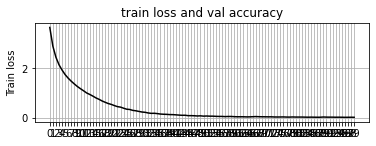

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


Finished Training


In [ ]:
plt.subplot(2, 1, 1)
plt.ylabel('Train loss')
plt.plot(np.arange(EPOCHS), train_loss_over_epochs, 'k-')
plt.title('train loss and val accuracy')
plt.xticks(np.arange(EPOCHS, dtype=int))
plt.grid(True)
plt.show()

plt.subplot(2, 1, 2)
val_accuracy_over_epochs = torch.tensor(val_accuracy_over_epochs, device = 'cpu')
plt.plot(np.arange(EPOCHS), val_accuracy_over_epochs, 'b-')
plt.ylabel('Val accuracy')
plt.xlabel('Epochs')
plt.xticks(np.arange(EPOCHS, dtype=int))
plt.grid(True)
plt.savefig("plot.png")
plt.close(fig)
print('Finished Training')
# -------------

In [ ]:
########################################################################
# 5. Try the network on test data, and create .csv file
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
########################################################################

# Check out why .eval() is important!
# https://discuss.pytorch.org/t/model-train-and-model-eval-vs-model-and-model-eval/5744/2
net.eval()

total = 0
predictions = []
for data in testloader:
    images, labels = data

    # For training on GPU, we need to transfer net and data onto the GPU
    # http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-on-gpu
    if IS_GPU:
        images = images.cuda()
        labels = labels.cuda()
    
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    predictions.extend(list(predicted.cpu().numpy()))
    total += labels.size(0)

with open('submission_netid.csv', 'w') as csvfile:
    wr = csv.writer(csvfile, quoting=csv.QUOTE_ALL)
    wr.writerow(["Id", "Prediction1"])
    for l_i, label in enumerate(predictions):
        wr.writerow([str(l_i), str(label)])

In [ ]:


# Part 2
"""Headers"""
import os
import os.path as osp
import time

%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim

from torchvision import datasets
# Pre-Trained Model

#TODO1. Load pretrained resnet model. Experiment with different models. 

#TODO2: Replace last fc layer
from torchvision import models
#TODO3. Forward pass
class PreTrainedResNet(nn.Module):
  def __init__(self, num_classes, feature_extracting):
    super(PreTrainedResNet, self).__init__()
    
    #TODO1: Load pre-trained ResNet Model
    self.resnet18 = models.resnet18(pretrained=True)
    #self.droupout1 = nn.Dropout(0.25)

    #Set gradients to false
    if feature_extracting:
      for param in self.resnet18.parameters():
          param.requires_grad = False
    
    #Replace last fc layer
    num_feats = self.resnet18.fc.in_features
    
    #TODO2: Replace fc layer in resnet to a linear layer of size (num_feats, num_classes)
    #self.Layer1=nn.Linear(num_feats, num_classes)
    self.resnet18.fc=nn.Linear(num_feats, num_classes)
  def forward(self, x):
    #TODO3: Forward pass x through the model
    x = self.resnet18(x)
    return x

def train(model, optimizer, criterion, epoch, num_epochs):
  model.train()
  epoch_loss = 0.0
  epoch_acc = 0.0
   # Early stopping
  #last_loss = 100
  #patience = 2
  #triggertimes = 0

  for batch_idx, (images, labels) in enumerate(dataloaders['train']):
    #zero the parameter gradients
    optimizer.zero_grad()
    
    #move to GPU
    images, labels = images.cuda(), labels.cuda()
    
    #forward
    outputs = model.forward(images)
   # l1_penalty = torch.nn.L1Loss(size_average=False)
   # reg_loss = 0
   # for param in model.parameters():
   #   reg_loss += l1_penalty(param)

    #factor = 0.01 #lambda
    #loss = criterion(outputs, labels)+factor * reg_loss
    loss = criterion(outputs, labels)
    #l2_lambda = 0.001
    #l2_norm = sum(p.abs().sum()
    #              for p in model.parameters())
 
    #loss = loss + l2_lambda * l2_norm
    
    _, preds = torch.max(outputs.data, 1)
    
    loss.backward()
    optimizer.step()
    
    epoch_loss += loss.item()
    epoch_acc += torch.sum(preds == labels).item()
    
  epoch_loss /= dataset_sizes['train']
  epoch_acc /= dataset_sizes['train']
  
  print('TRAINING Epoch %d/%d Loss %.4f Accuracy %.4f' % (epoch, num_epochs, epoch_loss, epoch_acc))


In [ ]:
# Main

#1. Vary hyperparams
#2. Data augmentation
#TODO: Vary Hyperparams

NUM_EPOCHS = 50
LEARNING_RATE = 0.001
BATCH_SIZE = 32
RESNET_LAST_ONLY = True #Fine tunes only the last layer. Set to False to fine tune entire network

root_path = '/data/' #If your data is in a different folder, set the path accodordingly

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        #transforms.CenterCrop(224),
        transforms.RandomResizedCrop(size=224),
        #transforms.RandomRotation((0,180)),
        transforms.RandomHorizontalFlip(),
        #TODO: Transforms.RandomResizedCrop() instead of CenterCrop(), RandomRoate() and Horizontal Flip()
        transforms.ToTensor(),
        transforms.Normalize((0.48, 0.456, 0.406),(0.229, 0.224, 0.225))
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        #transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.48, 0.456, 0.406),(0.229, 0.224, 0.225))
    ]),
}

# loading datasets with PyTorch ImageFolder
image_datasets = {x: datasets.ImageFolder(os.path.join(root_path, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}

# defining data loaders to load data using image_datasets and transforms, here we also specify batch size for the mini batch
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

#Initialize the model
model = PreTrainedResNet(len(class_names), RESNET_LAST_ONLY)
model = model.cuda()

#Setting the optimizer and loss criterion
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
criterion = nn.CrossEntropyLoss()

#Begin Train
for epoch in range(NUM_EPOCHS):
  train(model, optimizer, criterion, epoch+1, NUM_EPOCHS)
  
print("Finished Training")
print("-"*10)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weigh

  0%|          | 0.00/44.7M [00:00<?, ?B/s]

TRAINING Epoch 1/50 Loss 0.1692 Accuracy 0.0060
TRAINING Epoch 2/50 Loss 0.1611 Accuracy 0.0213
TRAINING Epoch 3/50 Loss 0.1551 Accuracy 0.0517
TRAINING Epoch 4/50 Loss 0.1486 Accuracy 0.0920
TRAINING Epoch 5/50 Loss 0.1434 Accuracy 0.1317
TRAINING Epoch 6/50 Loss 0.1383 Accuracy 0.1910
TRAINING Epoch 7/50 Loss 0.1331 Accuracy 0.2347
TRAINING Epoch 8/50 Loss 0.1286 Accuracy 0.2720
TRAINING Epoch 9/50 Loss 0.1242 Accuracy 0.2983
TRAINING Epoch 10/50 Loss 0.1204 Accuracy 0.3507
TRAINING Epoch 11/50 Loss 0.1165 Accuracy 0.3710
TRAINING Epoch 12/50 Loss 0.1129 Accuracy 0.3917
TRAINING Epoch 13/50 Loss 0.1097 Accuracy 0.4260
TRAINING Epoch 14/50 Loss 0.1062 Accuracy 0.4453
TRAINING Epoch 15/50 Loss 0.1031 Accuracy 0.4670
TRAINING Epoch 16/50 Loss 0.1007 Accuracy 0.4850
TRAINING Epoch 17/50 Loss 0.0977 Accuracy 0.4993
TRAINING Epoch 18/50 Loss 0.0962 Accuracy 0.4947
TRAINING Epoch 19/50 Loss 0.0930 Accuracy 0.5217
TRAINING Epoch 20/50 Loss 0.0909 Accuracy 0.5507
TRAINING Epoch 21/50 Loss 0.0

KeyboardInterrupt: ignored

In [ ]:


# Test
def test(model, criterion, repeats=2):
  model.eval()
  
  test_loss = 0.0
  test_acc = 0.0
  
  with torch.no_grad():
    for itr in range(repeats):
      for batch_idx, (images, labels) in enumerate(dataloaders['test']):
        #move to GPU
        images, labels = images.cuda(), labels.cuda()

        #forward
        outputs = model.forward(images)

        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs.data, 1)

        test_loss += loss.item()
        test_acc += torch.sum(preds == labels).item()

    test_loss /= (dataset_sizes['test']*repeats)
    test_acc /= (dataset_sizes['test']*repeats)

    print('Test Loss: %.4f Test Accuracy %.4f' % (test_loss, test_acc))

test(model, criterion)


Test Loss: 0.0820 Test Accuracy 0.4224


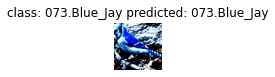

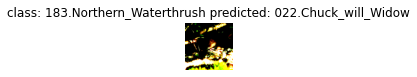

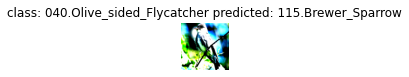

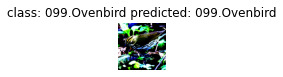

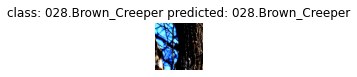

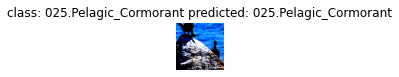

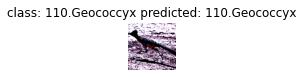

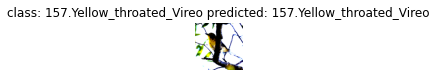

In [ ]:
# Visualizing the model predictions

#Only for viusalizing. Nothing to be done here. 
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(1)  # pause a bit so that plots are updated
    
def visualize_model(model, num_images=8):
    images_so_far = 0
    fig = plt.figure()

    for batch_idx, (images, labels) in enumerate(dataloaders['test']):
        #move to GPU
        images, labels = images.cuda(), labels.cuda()
        
        outputs = model(images)
        
        _, preds = torch.max(outputs.data, 1)
       

        for j in range(images.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('class: {} predicted: {}'.format(class_names[labels.data[j]], class_names[preds[j]]))

            imshow(images.cpu().data[j])

            if images_so_far == num_images:
                return
visualize_model(model)